In [ ]:
!pip install -qq datasets transformers[sentencepiece]
!pip install  -qq fastai 
!pip install -qq ohmeow-blurr 
!pip install -qq sacrebleu

     |████████████████████████████████| 298 kB 7.1 MB/s 
     |████████████████████████████████| 3.4 MB 45.6 MB/s 
     |████████████████████████████████| 61 kB 461 kB/s 
     |████████████████████████████████| 243 kB 51.2 MB/s 
     |████████████████████████████████| 1.1 MB 49.2 MB/s 
     |████████████████████████████████| 132 kB 61.6 MB/s 
     |████████████████████████████████| 160 kB 54.7 MB/s 
     |████████████████████████████████| 192 kB 39.6 MB/s 
     |████████████████████████████████| 271 kB 58.6 MB/s 
     |████████████████████████████████| 895 kB 50.2 MB/s 
     |████████████████████████████████| 3.3 MB 45.5 MB/s 
     |████████████████████████████████| 596 kB 38.5 MB/s 
     |████████████████████████████████| 1.2 MB 42.3 MB/s 
     |████████████████████████████████| 91 kB 5.3 MB/s 
     |████████████████████████████████| 189 kB 24.9 MB/s 
     |████████████████████████████████| 43 kB 1.8 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
     |█████████████████

#Import 

In [ ]:
import ast, inspect, torch
from typing import Any, Callable, Dict, List, Optional, Union, Type

from datasets import load_metric as hf_load_metric, list_metrics as hf_list_metrics
from fastcore.all import *
from fastai.callback.all import *
from fastai.data.block import DataBlock, ColReader, ItemGetter, ColSplitter, RandomSplitter
from fastai.data.core import DataLoader, DataLoaders, TfmdDL
from fastai.imports import *
from fastai.learner import *
from fastai.losses import CrossEntropyLossFlat
from fastai.optimizer import Adam, ranger, OptimWrapper, params
from fastai.torch_core import *
from fastai.torch_imports import *
from fastprogress.fastprogress import progress_bar,master_bar
from transformers import (
    AutoModelForSeq2SeqLM, logging,
    PretrainedConfig, PreTrainedTokenizerBase, PreTrainedModel
)

from blurr.utils import BLURR
from blurr.data.seq2seq.core import HF_Seq2SeqBlock, HF_Seq2SeqBeforeBatchTransform, default_text_gen_kwargs
from blurr.modeling.core import HF_BaseModelWrapper, HF_BaseModelCallback, HF_PreCalculatedLoss, Blearner
from blurr.modeling.seq2seq.core import HF_Seq2SeqMetricsCallback, seq2seq_splitter

logging.set_verbosity_error()

In [ ]:
import os, ast, inspect, pdb
from functools import reduce

from datasets import list_datasets, load_dataset
from fastai.data.external import untar_data, URLs
from fastcore.test import *
from transformers import BartForConditionalGeneration

from blurr.utils import print_versions

os.environ["TOKENIZERS_PARALLELISM"] = "false"
print_versions('torch fastai transformers')

torch: 1.10.0+cu111
fastai: 2.5.3
transformers: 4.14.1


#Dataset

In [ ]:
ds = load_dataset("mt_eng_vietnamese",'iwslt2015-en-vi')

Downloading:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.1M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/140k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/188k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/132k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/184k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset mt_eng_vietnamese downloaded and prepared to /root/.cache/huggingface/datasets/mt_eng_vietnamese/iwslt2015-en-vi/1.0.0/53add551a01e9874588066f89d42925f9fad43db347199dad00f7e4b0c905a71. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
print(f'{ds}\n')
print(f'{ds["train"][0]}\n')
print(f'{ds["train"].features}\n')

DatasetDict({
    train: Dataset({
        features: ['translation'],
        num_rows: 133318
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 1269
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 1269
    })
})

{'translation': {'en': 'Rachel Pike : The science behind a climate headline', 'vi': 'Khoa học đằng sau một tiêu đề về khí hậu'}}

{'translation': Translation(languages=('en', 'vi'), id=None)}



In [ ]:
train_df = pd.DataFrame(ds['train']['translation'], columns=['en', 'vi'])
valid_df = pd.DataFrame(ds['validation']['translation'], columns=['en', 'vi'])
train_df['is_valid']=False
valid_df['is_valid']=True
df = pd.concat([train_df, valid_df]).reset_index(drop=True)

In [ ]:
df.tail(2)

,en,vi,is_valid
134585,Thank you very much .,Cảm ơn rất nhiều .,True
134586,,,True


#Preprocessing

In [ ]:
en_na = [i for i in range(len(df)) if len(df.iloc[i]['en'])==0]
print(en_na)

[469, 8695, 9762, 10707, 21738, 26408, 29494, 38600, 41017, 48825, 50894, 51586, 54158, 56297, 57140, 57746, 58330, 66260, 68755, 73578, 76896, 77188, 79669, 87612, 88637, 89931, 94060, 104125, 104677, 107006, 112823, 115182, 116898, 119687, 119763, 119804, 120018, 120071, 120113, 120197, 120232, 120534, 120597, 120713, 120815, 120853, 120948, 121064, 121107, 121304, 121466, 121526, 121565, 121750, 121888, 121983, 122060, 122176, 122273, 122341, 122444, 122520, 122641, 122752, 122890, 123022, 123109, 123144, 123288, 123363, 123395, 123524, 123676, 123742, 123886, 123915, 124176, 124302, 124333, 124426, 124496, 124546, 124625, 124678, 124714, 124753, 124791, 124827, 124972, 125131, 125226, 125267, 125306, 125441, 125537, 125671, 125772, 126183, 126329, 126456, 126539, 126642, 126679, 126826, 126890, 126920, 127432, 127503, 127555, 127623, 127797, 127943, 128050, 128104, 128147, 128225, 128306, 128390, 128530, 128580, 128782, 128882, 129150, 129509, 129614, 129730, 129884, 130017, 130214

In [ ]:
vi_na = [i for i in range(len(df)) if len(df.iloc[i]['vi'])==0]
print(vi_na)

[119687, 119763, 119804, 120018, 120071, 120113, 120197, 120232, 120534, 120597, 120713, 120815, 120853, 120948, 121064, 121107, 121148, 121304, 121466, 121526, 121565, 121635, 121750, 121888, 121983, 122060, 122176, 122273, 122341, 122444, 122520, 122641, 122752, 122890, 123022, 123144, 123288, 123363, 123395, 123524, 123676, 123742, 123886, 123915, 124176, 124302, 124333, 124426, 124496, 124546, 124625, 124678, 124714, 124753, 124791, 124827, 125131, 125226, 125306, 125441, 125537, 125671, 125772, 126183, 126329, 126456, 126539, 126642, 126679, 126826, 126890, 126920, 127432, 127503, 127555, 127623, 127797, 127943, 128050, 128147, 128225, 128306, 128390, 128530, 128580, 128782, 128882, 129150, 129509, 129614, 129730, 129884, 130017, 130324, 130543, 130765, 130970, 131047, 131110, 131178, 131345, 131629, 131796, 131938, 132082, 132330, 132433, 132543, 132692, 133020, 133147, 133314, 133317, 134586]


In [ ]:
df = df.drop(en_na+vi_na).reset_index(drop=True) # xóa các dòng có giá trị là ''
df.shape

(134434, 3)

In [ ]:
df["en"] = df["en"].replace(["&apos;d","&apos;s","&apos;ve","&apos;t","&apos;re","&apos;ll","&apos;m","&apos;","&quot;","&amp;","&#91;","&#93;"
,"&apos;clock","&apos;all","&apos;s-eye","&apos;mon","&apos;am"], ["'d","'s","'ve","'t","'re","'ll","'m","'",'"',"&","[","]","'clock","'all","'s-eye","'mon","'am"] ,regex=True)

df["vi"] = df["vi"].replace(["&apos;d","&apos;s","&apos;ve","&apos;t","&apos;re","&apos;ll","&apos;m","&apos;","&quot;","&amp;","&#91;","&#93;"
,"&apos;clock","&apos;all","&apos;s-eye","&apos;mon","&apos;am"], ["'d","'s","'ve","'t","'re","'ll","'m","'",'"',"&","[","]","'clock","'all","'s-eye","'mon","'am"] ,regex=True)

In [ ]:
df.iloc[460:470]

,en,vi,is_valid
460,It could be anti-bacterial .,Có thể là chống vi khuẩn .,False
461,"Without water , the bacteria won 't survive .","Không có nước , vi khuẩn không kí sinh được .",False
462,And it could be things that need to be self-cleaning as well .,Và tất cả những chất tự rửa,False
463,So imagine how something like this could help revolutionize your field of work .,Thử tưởng tượng những ứng dụng này có thể cải tiến lĩnh vực bạn đang làm .,False
464,"And I 'm going to leave you with one last demonstration , but before I do that , I would like to say thank you , and think small .","Sau đây là bài biểu diễn cuối cùng của tôi , nhưng trước đó , tôi muốn cảm ơn tất cả các bạn , và nghĩ ít thôi nhé .",False
465,It 's going to happen . Wait for it . Wait for it .,Sẽ được thôi . Từ từ .,False
466,You guys didn 't hear about us cutting out the Design from TED ?,Bạn biết chúng tôi cắt biển hiệu của chương trình TED chứ ?,False
467,[ Two minutes later ... ] He ran into all sorts of problems in terms of managing the medical research part .,[ Hai phút sau ... ] Ông ấy có rất nhiều nghiên cứu y học .,False
468,It 's happening !,Được rồi !,False
469,Dan Ariely : Our buggy moral code,Dan Ariely bàn về đoạn mã đạo đức bị lỗi của con người,False


In [ ]:
df.tail(2)

,en,vi,is_valid
134432,"I hope that these images awaken a force in those who view them , people like you , and I hope that force will ignite a fire , and that fire will shine a light on slavery , for without that light , the beast of bondage can continue to live in the shadows .","Tôi hi vọng những tấm hình sẽ đánh thức một nguồn sức mạnh trong người xem , những người như bạn , và hi vọng sức mạnh đó sẽ châm ngọn lửa , ngọn lửa đó sẽ chiếu rọi vào nạn nô lệ , vì không có ánh sáng đó , con quái vật của ngục tù sẽ có thể tiếp tục sống trong bóng tối .",True
134433,Thank you very much .,Cảm ơn rất nhiều .,True


In [ ]:
pretrained_model_name = "Helsinki-NLP/opus-mt-en-vi"
model_cls = AutoModelForSeq2SeqLM

hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(pretrained_model_name, model_cls=model_cls) # get object 
hf_arch, type(hf_tokenizer), type(hf_config), type(hf_model)

('marian',
 transformers.models.marian.tokenization_marian.MarianTokenizer,
 transformers.models.marian.configuration_marian.MarianConfig,
 transformers.models.marian.modeling_marian.MarianMTModel)

In [ ]:
print(hf_tokenizer), print(hf_config), print(hf_model)

PreTrainedTokenizer(name_or_path='Helsinki-NLP/opus-mt-en-vi', vocab_size=53685, model_max_len=512, is_fast=False, padding_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'})
MarianConfig {
  "_name_or_path": "Helsinki-NLP/opus-mt-en-vi",
  "activation_dropout": 0.0,
  "activation_function": "swish",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "MarianMTModel"
  ],
  "attention_dropout": 0.0,
  "bad_words_ids": [
    [
      53684
    ]
  ],
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 512,
  "decoder_attention_heads": 8,
  "decoder_ffn_dim": 2048,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 6,
  "decoder_start_token_id": 53684,
  "dropout": 0.1,
  "encoder_attention_heads": 8,
  "encoder_ffn_dim": 2048,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 6,
  "eos_token_id": 0,
  "extra_pos_embeddings": 53685,
  "forced_eos_token_id": 0,
  "id2label": {
    

(None, None, None)

In [ ]:
inputs = hf_tokenizer("It 's happening !")
print(inputs)

{'input_ids': [98, 589, 11, 2607, 703, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}


In [ ]:
print(hf_tokenizer.decode(inputs['input_ids'])),
print(hf_tokenizer.convert_ids_to_tokens(inputs.input_ids))

It's▁happening!
['▁It', "▁'", 's', '▁happening', '▁!', '</s>']


In [ ]:
print(max([len(hf_tokenizer(df['en'][i]).input_ids) for i in range(len(df))])),
print(max([len(hf_tokenizer(df['vi'][i]).input_ids) for i in range(len(df))]))

772
2092


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


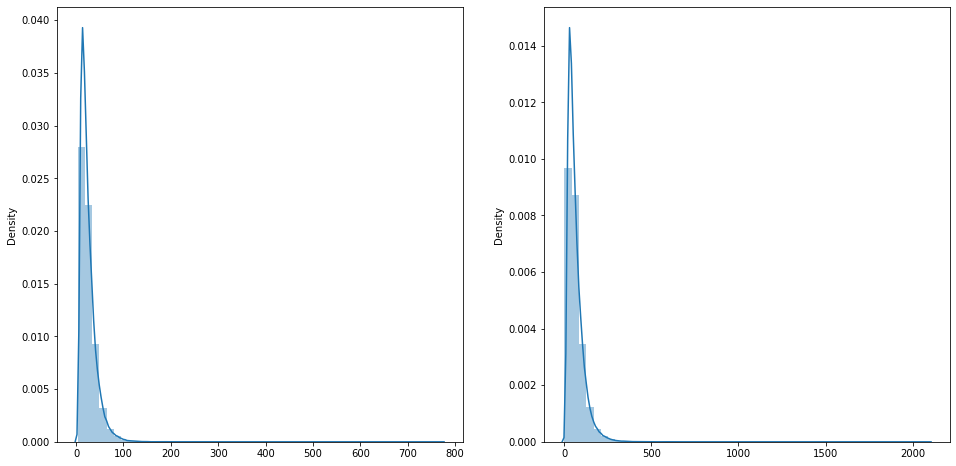

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,8))
sns.distplot([len(hf_tokenizer(df['en'][i]).input_ids) for i in range(len(df))],ax=ax1)
sns.distplot([len(hf_tokenizer(df['vi'][i]).input_ids) for i in range(len(df))],ax=ax2)

In [ ]:
en_256 = [len(hf_tokenizer(df['en'][i]).input_ids) for i in range(len(df))]
print(len([s for s in en_256 if s > 256])) #  36 câu tiếng anh có nhiều hơn 256 tokens

32


In [ ]:
vi_256= [len(hf_tokenizer(df['vi'][i]).input_ids) for i in range(len(df))]
print(len([s for s in vi_256 if s > 256])) # có 796 câu tiếng việt có nhiều hơn 256 tokens.

774


In [ ]:
blocks = (HF_Seq2SeqBlock(hf_arch, hf_config, hf_tokenizer, hf_model), noop)  # sử dụng max_length mặc định = 512
dblock = DataBlock(blocks=blocks, get_x=ColReader('en'), get_y=ColReader('vi'), splitter=ColSplitter('is_valid'))

In [ ]:
dls = dblock.dataloaders(df, bs=4) # chuẩn bị data để đưa vào mô hình.

In [ ]:
dls.valid_ds[0]

('When I was little , I thought my country was the best on the planet , and I grew up singing a song called " Nothing To Envy . "',
 'Khi tôi còn nhỏ , Tôi nghĩ rằng BắcTriều Tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài " Chúng ta chẳng có gì phải ghen tị . "')

In [ ]:
b = dls.one_batch()

In [ ]:
b[0]

{'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0'),
 'input_ids': tensor([[ 6251,  1600,  5294,  ...,    13,   440,     0],
         [  102,   231,    12,  ..., 53684, 53684, 53684],
         [ 2852, 11761,  5892,  ..., 53684, 53684, 53684],
         [ 9016,   135,    15,  ..., 53684, 53684, 53684]], device='cuda:0'),
 'labels': tensor([[ 6251,  1600,  5294,  ...,   369,   370,     0],
         [  162,    91,   118,  ..., 53684, 53684, 53684],
         [ 2852, 11761,   604,  ..., 53684, 53684, 53684],
         [ 6477,  1161,   274,  ..., 53684, 53684, 53684]], device='cuda:0')}

In [ ]:
len(b), b[0]['input_ids'].shape,  b[1].shape

(2, torch.Size([4, 512]), torch.Size([4, 512]))

In [ ]:
dls.valid.show_batch(dataloaders=dls, max_n=2, input_trunc_at=256, target_trunc_at=256)

,text,target
0,"▁Instead, Conor came home one Friday▁evening and he told me that he had▁quit his job that day, his dream job, and he▁said that he had▁quit his job because of me, because I had made him feel so▁safe and▁loved that he▁didn 't need to▁prove▁himself on Wall St","Thay vì vậy, Conor đã về nhà vào một tối thứ sáu và anh ấy nói với tôi rằng anh ấy nghỉ việc ngày hôm nay công việc mơ ước của anh ta, và anh ta nói rằng, anh ta bỏ việc vì tôi, bởi vì tôi làm anh cảm thấy thật an toàn và được yêu thương rằng anh ta không"
1,"And he▁also▁created a▁magical▁atmosphere of▁trust▁between us by▁confessing his▁secret,▁which was that, as a▁very▁young boy▁starting at age four, he had▁been▁savagely and▁repeatedly▁physically▁abused by his▁stepfather, and the▁abuse had▁gotten so▁bad that h","Và anh ta cũng tạo ra bầu không khí huyền diệu của sự tin tưởng giữa chúng tôi bằng cách thú nhận những bí mật của anh ta, rằng, anh ta như là một đứa trẻ từ lúc bốn tuổi đã bị ngược đãi về thân thể một cách độc ác và liên tục bởi cha dượng của anh ta, và"


#Model

In [ ]:
seq2seq_metrics = {
    'bleu': { 'returns': "bleu" },
    'sacrebleu': { 'returns': "score" }
}

model = HF_BaseModelWrapper(hf_model)

learn_cbs = [HF_BaseModelCallback]
fit_cbs = [HF_Seq2SeqMetricsCallback(custom_metrics=seq2seq_metrics)]

learn = Learner(dls, 
                model,
                opt_func=partial(Adam),
                loss_func=CrossEntropyLossFlat(), 
                cbs=learn_cbs,
                splitter=partial(seq2seq_splitter, arch=hf_arch)).to_fp16()

learn.freeze()

Downloading:   0%|          | 0.00/2.49k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.55k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.37k [00:00<?, ?B/s]

In [ ]:
b = dls.one_batch()
preds = learn.model(b[0])

In [ ]:
preds['loss'], preds['logits'].shape, preds['encoder_last_hidden_state'].shape

(tensor(4.9703, device='cuda:0', grad_fn=<NllLossBackward0>),
 torch.Size([4, 512, 53685]),
 torch.Size([4, 512, 512]))

In [ ]:
len(b), len(b[0]), b[0]['input_ids'].shape, len(b[1]), b[1].shape

(2, 3, torch.Size([4, 512]), 4, torch.Size([4, 512]))

In [ ]:
print(len(learn.opt.param_groups))

3


SuggestedLRs(minimum=0.00012022644514217973, steep=6.309573450380412e-07, valley=0.00010964782268274575, slide=0.0002290867705596611)

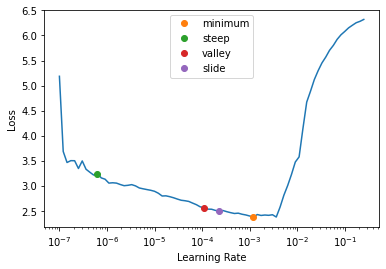

In [ ]:
learn.lr_find(suggest_funcs=[minimum, steep, valley, slide]) # find learning rate

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-4, cbs=fit_cbs)  

epoch,train_loss,valid_loss,bleu,sacrebleu,time
0,1.434009,1.269526,0.346633,34.872100,53:31
1,1.347555,1.217954,0.348975,35.144520,53:59
2,1.084932,1.193897,0.352389,35.453794,53:05


In [ ]:
learn.show_results(learner=learn, input_trunc_at=256, target_trunc_at=256, max_n=2)

,text,target,prediction
0,"▁Instead, Conor came home one Friday▁evening and he told me that he had▁quit his job that day, his dream job, and he▁said that he had▁quit his job because of me, because I had made him feel so▁safe and▁loved that he▁didn 't need to▁prove▁himself on Wall St","Thay vì vậy, Conor đã về nhà vào một tối thứ sáu và anh ấy nói với tôi rằng anh ấy nghỉ việc ngày hôm nay công việc mơ ước của anh ta, và anh ta nói rằng, anh ta bỏ việc vì tôi, bởi vì tôi làm anh cảm thấy thật an toàn và được yêu thương rằng anh ta không","Thay vào đó , Conor trở về nhà vào một buổi tối thứ sáu và nói với tôi rằng anh ấy đã bỏ việc hôm đó , công việc mơ ước của anh ấy , và anh ấy nói rằng anh ấy đã bỏ việc vì tôi , bởi vì tôi đã làm cho anh ấy cảm thấy rất an toàn và được yêu rằng anh ấy khô"
1,"I made this last▁year, and▁started▁receiving▁hundreds of▁messages from▁passionate people who▁wanted to make a wall with▁their▁community, so my▁civic▁center▁colleagues and I made a▁tool▁kit, and now▁walls have▁been made in▁countries around the world,▁includ","Tôi làm dự án này năm ngoái, và bắt đầu nhận được hàng trăm lá thư từ những người nhiệt thành những người muốn làm một bức tường ở cộng đồng của họ, vì vậy các đồng nghiệp dân cư trung tâm và tôi làm một công cụ, và bây giờ những bức tường đã đang được làm","Tôi đã thực hiện năm ngoái , và bắt đầu nhận được hàng trăm thông điệp từ những người đam mê muốn tạo ra một bức tường với cộng đồng của họ , vì vậy , những đồng nghiệp của tôi và tôi đã làm một bộ dụng cụ , và bây giờ những bức tường đã được làm ra ở nhữn"


#Inference

In [ ]:
test_en = "Hi my group gonna get a good result."

In [ ]:
outputs = learn.blurr_generate(test_en, num_return_sequences=3)

for idx, o in enumerate(outputs):
    print(f'=== Prediction {idx+1} ===\n{o}\n')

=== Prediction 1 ===
Chào nhóm của tôi sẽ có kết quả tốt .

=== Prediction 2 ===
Xin chào nhóm của tôi sẽ có kết quả tốt .

=== Prediction 3 ===
Chào nhóm của tôi sẽ đạt được kết quả tốt .



#Test score

In [ ]:
test_set = pd.DataFrame(ds['test']['translation'], columns=['en', 'vi']); len(test_set)

1269

In [ ]:
en_na_test = [i for i in range(len(test_set)) if len(test_set.iloc[i]['en'])==0]
print(en_na_test)

[1268]


In [ ]:
vi_na_test = [i for i in range(len(test_set)) if len(test_set.iloc[i]['vi'])==0]
print(vi_na_test)

[1268]


In [ ]:
test_set = test_set.drop(1268)

In [ ]:
test_set["en"] = test_set["en"].replace(["&apos;d","&apos;s","&apos;ve","&apos;t","&apos;re","&apos;ll","&apos;m","&apos;","&quot;","&amp;","&#91;","&#93;"
,"&apos;clock","&apos;all","&apos;s-eye","&apos;mon","&apos;am"], ["'d","'s","'ve","'t","'re","'ll","'m","'",'"',"&","[","]","'clock","'all","'s-eye","'mon","'am"] ,regex=True)

test_set["vi"] = test_set["vi"].replace(["&apos;d","&apos;s","&apos;ve","&apos;t","&apos;re","&apos;ll","&apos;m","&apos;","&quot;","&amp;","&#91;","&#93;"
,"&apos;clock","&apos;all","&apos;s-eye","&apos;mon","&apos;am"], ["'d","'s","'ve","'t","'re","'ll","'m","'",'"',"&","[","]","'clock","'all","'s-eye","'mon","'am"] ,regex=True)

In [ ]:
test_set.sample(10)

,en,vi
139,"Because it 's very hollow , all the noise will disappear , so it 's a very silent road .","Bởi vì nó rất rỗng , tất cả tiếng ồn sẽ biến mất , vì thế mà con đường rất yên tĩnh ."
654,Here 's me at a slumber party a few days before I shot French Vogue .,Đây là tôi ở tiệc ngủ vài ngày trước khi chụp ảnh cho Vogue Pháp .
251,"The other question everybody asks is , why doesn 't she just leave ?","Câu hỏi khác mà mọi người hay hỏi là , tại sao cô ấy lại không bỏ đi ?"
349,We would cover our books in grocery bags so it would seem we were just out shopping .,Chúng tôi giấu sách vở trong giỏ đi chợ như thế mọi người sẽ nghĩ chúng tôi chỉ đi mua sắm .
880,Thank you .,Cảm ơn .
690,"I feel like every time someone sneezes , New Orleans has a parade .","Tôi cảm thấy giống mỗi lần ai đó hắt xì , New Orleans có cả một cuộc diễu hành ."
346,"So for the next five years , I dressed as a boy to escort my older sister , who was no longer allowed to be outside alone , to a secret school .","Trong 5 năm sau đó , tôi đã ăn mặc như 1 thằng con trai để đi cùng với chị tôi tới một trường bí mật vì chị tôi bị cấm ra khỏi nhà môt mình ."
1229,"Terrified of his master , he will not run away , and since he 's been treated with cruelty all his life , he passes that down to the younger slaves that he manages .","Quá sợ người chủ , em không dám chạy trốn , và vì bị đối xử tàn tệ từ nhỏ , em tiếp diễn điều đó xuống những nô lệ nhỏ hơn mà em quản lý ."
587,"Instead , as Einstein said , make everything as simple as possible , but no simpler .","Thay vào đó , như Anh-xtanh đã nói : biến mọi thứ càng đơn giản càng tốt , nhưng đừng đơn giản hơn ."
1196,"This wasn 't a brothel , per se .",Nơi đây thực chất không phải nhà thổ .


In [ ]:
metric = hf_load_metric("sacrebleu")

In [ ]:
test_score= []
for i in range(len(test_set)):
  output = learn.blurr_generate(test_set['en'][i], num_return_sequences=1)
  result = metric.compute(predictions=output, references=[[test_set['vi'][i]]])['score']
  test_score.append(result)
print(test_score)

[10.396894088687255, 29.640095400745814, 45.05929961528081, 17.273167210990284, 26.666078773003335, 41.682189465797684, 35.14760418456269, 7.877450962109513, 21.658670514848044, 30.213753973567677, 37.51840463233444, 26.92774258928226, 22.18554028345633, 26.24310277292268, 12.107470158860226, 52.634723973110134, 23.18566067387828, 28.986413492880956, 20.2132331101125, 47.22938941400709, 6.674094719041481, 21.414818552625793, 28.997844147152072, 44.96754147036131, 35.27295712700594, 10.02653868126328, 16.424523775288232, 35.27762412263182, 21.066551867537054, 53.338772196871474, 44.09608678591974, 11.70108069631451, 19.35661130226731, 36.876567565439856, 11.88359194952101, 51.93071778680675, 38.386658421682654, 19.172737289612076, 44.12484512922978, 13.13748219776422, 34.91665073071338, 37.860842418991226, 8.383924775392588, 13.929083599454676, 12.806473847444227, 38.29952874819772, 30.415590104969052, 13.573105058551016, 35.06964631324619, 21.84971203531727, 37.868117902707674, 19.4375

In [ ]:
from statistics import mean
mean(test_score)

33.08584714708631

#Share model

In [ ]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/token.
        (Deprecated, will be removed in v0.3.0) To login with username and password instead, interrupt with Ctrl+C.
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine

In [ ]:
!sudo apt-get install git-lfs

In [ ]:
!git config --global user.email "haotieu1601@gmail.com"
!git config --global user.name "haotieu"

In [ ]:
from blurr.data.core import get_blurr_tfm
blurr_tfm = get_blurr_tfm(learn.dls.before_batch)

In [ ]:
blurr_tfm.hf_model.push_to_hub("en-vi-mt-model",use_temp_dir=True)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:726: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/haotieu/en-vi-mt-model into local empty directory.
To https://huggingface.co/haotieu/en-vi-mt-model
   daca6cc..bc7866a  main -> main



'https://huggingface.co/haotieu/en-vi-mt-model/commit/bc7866a947163b0e7aaef000ce256cb320c0bff2'

In [ ]:
blurr_tfm.hf_tokenizer.push_to_hub("en-vi-mt-model",use_temp_dir=True)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/hf_api.py:726: FutureWarning: `create_repo` now takes `token` as an optional positional argument. Be sure to adapt your code!
  FutureWarning,
Cloning https://huggingface.co/haotieu/en-vi-mt-model into local empty directory.
To https://huggingface.co/haotieu/en-vi-mt-model
   bc7866a..97c5817  main -> main



'https://huggingface.co/haotieu/en-vi-mt-model/commit/97c5817edaf4ae2cdf161632c3897ced4304e273'

#Use model

In [ ]:
from transformers import pipeline

In [ ]:
trans = pipeline("translation", model="haotieu/en-vi-mt-model")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/274M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/298 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/790k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/738k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.24M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

In [ ]:
trans("Pfizer's updated results for its experimental treatment for Covid-19 showed it cut the risk of hospitalization or death by 89% if given to high-risk adults within a few days of their first symptoms, the company announced in a news release Tuesday.")

[{'translation_text': 'Pfizer đã cập nhật kết quả cho việc thực nghiệm điều trị cho Covid-19 cho thấy nó cắt giảm nguy cơ bệnh viện hoặc tử vong đến 89 % nếu được đưa cho những người lớn có nguy cơ cao trong vòng vài ngày triệu chứng đầu tiên của họ , công ty thông báo trong một bản tin ngày thứ ba .'}]